In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/09/14 21:00:45 WARN Utils: Your hostname, LAPTOP-URHBN55Q resolves to a loopback address: 127.0.1.1; using 10.13.193.65 instead (on interface wifi0)
22/09/14 21:00:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/14 21:00:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load all transactions datasets
paths=['../data/tables/transactions_20210228_20210827_snapshot',
       '../data/tables/transactions_20210828_20220227_snapshot',
       '../data/tables/transactions_20220228_20220828_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added transactions_20210228_20210827_snapshot
added transactions_20210828_20220227_snapshot
added transactions_20220228_20220828_snapshot


In [4]:
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [5]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [74]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [75]:
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [76]:
df_trx = df_trx.withColumn("tags", normalize_tags(F.col("tags")))
df_trx = df_trx.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))
df_trx = df_trx.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("take_rate", F.col("take_rate").astype(FloatType()))
df_trx = df_trx.withColumn("categories", clean_string(F.col("categories")))
df_trx = df_trx.where(F.col("dollar_value") >= 35)

In [7]:
fraud_data_consumer = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True)
fraud_data_merchant = spark.read.csv("../data/tables/merchant_fraud_probability.csv", header=True)

In [85]:
fraud_trx = df_trx.join(fraud_data_merchant, on=["merchant_abn", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_merchant_pr")
fraud_trx = fraud_trx.join(fraud_data_consumer, on=["user_id", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_consumer_pr")
fraud_trx = fraud_trx.where((F.col("fraud_merchant_pr").isNotNull()) | F.col("fraud_consumer_pr").isNotNull())


In [11]:
fraud_trx.groupby("categories").agg({"dollar_value": "mean"})

categories,avg(dollar_value)
"opticians, optica...",180.11468203299097
"watch, clock, and...",113.45844502135355
computer programm...,306.88873737355806
digital goods: bo...,92.15849660635749
"books, periodical...",370.69060410569057
florists supplies...,227.97766825800727
art dealers and g...,4209.980883118837
antique shops - s...,9552.813136488116
"gift, card, novel...",96.36398334276166
"equipment, tool, ...",3874.051815188241


In [12]:
fraud_trx.groupby("categories").agg(F.percentile_approx("dollar_value", 0.5).alias("median"))

categories,median
"opticians, optica...",106.30811865982163
"watch, clock, and...",88.74585943337901
computer programm...,198.5768271480985
digital goods: bo...,79.02363115111925
"books, periodical...",284.4484332983803
florists supplies...,121.16742730371777
art dealers and g...,3515.971581731779
antique shops - s...,6760.640583371255
"gift, card, novel...",83.20861964063579
"equipment, tool, ...",3544.4178736935846


In [13]:
fraud_trx.groupby("categories").agg({"dollar_value": "stddev"})

categories,stddev(dollar_value)
"opticians, optica...",190.00400833170363
"watch, clock, and...",80.85341016614638
computer programm...,700.709065391746
digital goods: bo...,50.3232631504141
"books, periodical...",324.5445476180074
florists supplies...,249.99728043564565
art dealers and g...,3575.431973582655
antique shops - s...,10196.020648698974
"gift, card, novel...",52.70280793902172
"equipment, tool, ...",1773.4699154320263


In [68]:
@F.udf(FloatType())
def get_mean(col1, col2):
    if col1 and col2:
        return (col1 + col2)/2
    elif not col2:
        return col1
    else:
        return col2

In [86]:
fraud_trx = fraud_trx.withColumn("fraud_merchant_pr", F.col("fraud_merchant_pr").astype(FloatType()))
fraud_trx = fraud_trx.withColumn("fraud_consumer_pr", F.col("fraud_consumer_pr").astype(FloatType()))

In [87]:
fraud_trx = fraud_trx.withColumn("fraud_mean", get_mean(F.col("fraud_merchant_pr"), F.col("fraud_consumer_pr")))

In [88]:
pd_fraud = fraud_trx.toPandas()

In [64]:
pd_fraud

,user_id,order_datetime,merchant_abn,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,merchant_name,tags,categories,revenue_level,take_rate,fraud_merchant_pr,fraud_consumer_pr,fraud_mean
0,19,2021-11-27,73918814753,1226530,Victoria Gonzalez,68657 Johnson Glen Suite 266,TAS,7276,Female,2809.102513,0470fa28-6af7-4a6b-b9be-9971dfb99469,Venenatis Lacus Etiam LLC,"[furniture, home furnishings and equipment sho...","furniture, home furnishings and equipment shop...",b,4.99,NaN,14.310022,14.310022
1,19,2021-11-27,26267439458,1226530,Victoria Gonzalez,68657 Johnson Glen Suite 266,TAS,7276,Female,125.572940,e6cf3054-e5bc-4be6-99f7-41f72a54403d,Aliquam Fringilla Foundation,"[furniture, home furnishings and equipment sho...","furniture, home furnishings and equipment shop...",c,2.75,NaN,14.310022,14.310022
2,22,2021-11-03,86710922099,738803,Christopher Whitehead,04814 Erin Port Apt. 649,VIC,3378,Male,2272.177699,eb19e290-2334-4b39-a161-c508793c0ace,Ac Urna Consulting,"[art dealers and galleries], [b], [take rate: ...",art dealers and galleries,b,4.25,NaN,10.569931,10.569931
3,26,2021-11-19,11237511112,1421465,Kristi Adkins,051 Snyder Hollow Suite 867,VIC,3469,Female,623.291115,0660b5c0-8b34-4d04-af09-cd01f7a5793e,Magna Institute,"[opticians, optical goods, and eyeglasses], [c...","opticians, optical goods, and eyeglasses",c,2.11,NaN,10.604536,10.604536
4,26,2021-11-19,96323146873,1421465,Kristi Adkins,051 Snyder Hollow Suite 867,VIC,3469,Female,1975.690954,4801059a-17e1-4374-a1d6-ce7fb64cde99,A Facilisis Limited,"[tent and awning shops], [b], [take rate: 4.42]",tent and awning shops,b,4.42,NaN,10.604536,10.604536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62057,23844,2021-09-14,88040874613,712466,Glenn Peterson,5203 Alexis Cape,QLD,4880,Male,5570.186332,ff7aabd2-5a74-4653-8a8b-9e9669939edc,Dapibus Id Ltd,"[antique shops - sales, repairs, and restorati...","antique shops - sales, repairs, and restoratio...",b,3.90,NaN,19.165480,19.165480
62058,23994,2021-09-02,23338656015,860399,Sally Fry,5768 Alexander Squares Suite 668,SA,5167,Female,226.232122,388dae9a-55f6-4545-91b7-7e2be741f481,Iaculis LLC,"[watch, clock, And jewelry repair shops], [b],...","watch, clock, and jewelry repair shops",b,3.25,NaN,26.681465,26.681465
62059,24024,2021-09-14,87084550311,122986,Heather Todd,064 Steven Mountain Suite 468,VIC,3966,Female,4122.763519,cda592a9-0b45-4900-8fa6-3719c505cb39,Vulputate Inc.,"[bicycle shops - sales and seRvice], [b], [tak...",bicycle shops - sales and service,b,4.58,NaN,16.553917,16.553917
62060,24024,2021-09-14,17488304283,122986,Heather Todd,064 Steven Mountain Suite 468,VIC,3966,Female,97.128225,9f0a623c-720d-4908-a903-cf7f937f675e,Posuere Cubilia Curae Corporation,"[cable, satellite, and other pay television an...","cable, satellite, and other pay television and...",a,6.18,NaN,16.553917,16.553917


<AxesSubplot:xlabel='dollar_value', ylabel='fraud_mean'>

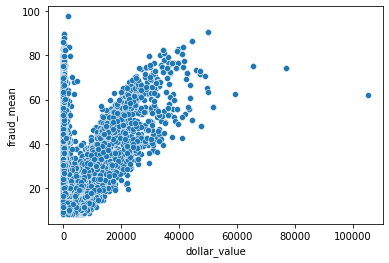

In [26]:
sns.scatterplot(pd_fraud["dollar_value"], pd_fraud["fraud_mean"])

In [23]:
pd_fraud_below_10k = pd_fraud[pd_fraud["dollar_value"] < 10000]

In [27]:
pd_fraud

,user_id,order_datetime,merchant_abn,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,merchant_name,tags,fraud_merchant_pr,fraud_consumer_pr,categories,revenue_level,take_rate,fraud_mean
0,19,2021-11-27,73918814753,1226530,Victoria Gonzalez,68657 Johnson Glen Suite 266,TAS,7276,Female,2809.102513,0470fa28-6af7-4a6b-b9be-9971dfb99469,Venenatis Lacus Etiam LLC,"[furniture, home furnishings and equipment sho...",NaN,14.310022,"furniture, home furnishings and equipment shop...",b,4.99,14.310022
1,19,2021-11-27,26267439458,1226530,Victoria Gonzalez,68657 Johnson Glen Suite 266,TAS,7276,Female,125.572940,e6cf3054-e5bc-4be6-99f7-41f72a54403d,Aliquam Fringilla Foundation,"[furniture, home furnishings and equipment sho...",NaN,14.310022,"furniture, home furnishings and equipment shop...",c,2.75,14.310022
2,22,2021-11-03,86710922099,738803,Christopher Whitehead,04814 Erin Port Apt. 649,VIC,3378,Male,2272.177699,eb19e290-2334-4b39-a161-c508793c0ace,Ac Urna Consulting,"[art dealers and galleries], [b], [take rate: ...",NaN,10.569931,art dealers and galleries,b,4.25,10.569931
3,26,2021-11-19,11237511112,1421465,Kristi Adkins,051 Snyder Hollow Suite 867,VIC,3469,Female,623.291115,0660b5c0-8b34-4d04-af09-cd01f7a5793e,Magna Institute,"[opticians, optical goods, and eyeglasses], [c...",NaN,10.604536,"opticians, optical goods, and eyeglasses",c,2.11,10.604536
4,26,2021-11-19,96323146873,1421465,Kristi Adkins,051 Snyder Hollow Suite 867,VIC,3469,Female,1975.690954,4801059a-17e1-4374-a1d6-ce7fb64cde99,A Facilisis Limited,"[tent and awning shops], [b], [take rate: 4.42]",NaN,10.604536,tent and awning shops,b,4.42,10.604536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62057,23844,2021-09-14,88040874613,712466,Glenn Peterson,5203 Alexis Cape,QLD,4880,Male,5570.186332,ff7aabd2-5a74-4653-8a8b-9e9669939edc,Dapibus Id Ltd,"[antique shops - sales, repairs, and restorati...",NaN,19.165480,"antique shops - sales, repairs, and restoratio...",b,3.90,19.165480
62058,23994,2021-09-02,23338656015,860399,Sally Fry,5768 Alexander Squares Suite 668,SA,5167,Female,226.232122,388dae9a-55f6-4545-91b7-7e2be741f481,Iaculis LLC,"[watch, clock, And jewelry repair shops], [b],...",NaN,26.681465,"watch, clock, and jewelry repair shops",b,3.25,26.681465
62059,24024,2021-09-14,87084550311,122986,Heather Todd,064 Steven Mountain Suite 468,VIC,3966,Female,4122.763519,cda592a9-0b45-4900-8fa6-3719c505cb39,Vulputate Inc.,"[bicycle shops - sales and seRvice], [b], [tak...",NaN,16.553917,bicycle shops - sales and service,b,4.58,16.553917
62060,24024,2021-09-14,17488304283,122986,Heather Todd,064 Steven Mountain Suite 468,VIC,3966,Female,97.128225,9f0a623c-720d-4908-a903-cf7f937f675e,Posuere Cubilia Curae Corporation,"[cable, satellite, and other pay television an...",NaN,16.553917,"cable, satellite, and other pay television and...",a,6.18,16.553917


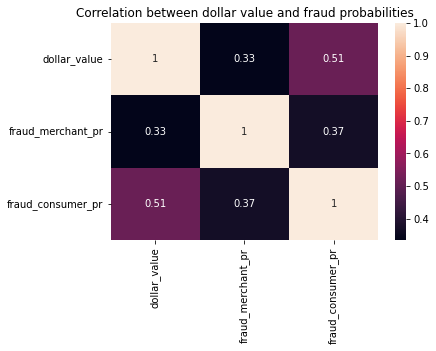

In [51]:
sns.heatmap(pd_fraud[["dollar_value", "fraud_merchant_pr", "fraud_consumer_pr"]].corr(), annot=True)
plt.title('Correlation between dollar value and fraud probabilities')
plt.show()

In [90]:
categories = pd_fraud["categories"].unique().tolist()

In [91]:
for category in categories:
    num_fraud = pd_fraud[pd_fraud["categories"] == category].shape[0]
    num_total = df_trx.where(F.col("categories") == category).count()
    print(f'Proportion of possible fraud in category {category} is {(num_fraud/num_total)*100}%')

Proportion of possible fraud in category furniture, home furnishings and equipment shops, and manufacturers, except appliances is 0.948072928686822%


Proportion of possible fraud in category art dealers and galleries is 14.0370123056377%


Proportion of possible fraud in category opticians, optical goods, and eyeglasses is 0.4751067905560051%


Proportion of possible fraud in category tent and awning shops is 0.7493929231269963%


Proportion of possible fraud in category gift, card, novelty, and souvenir shops is 0.33801387521040616%


Proportion of possible fraud in category antique shops - sales, repairs, and restoration services is 1.3206581258059709%


Proportion of possible fraud in category telecom is 13.279823733081523%


Proportion of possible fraud in category motor vehicle supplies and new parts is 1.1975551927994836%


Proportion of possible fraud in category stationery, office supplies and printing and writing paper is 0.8497357529061086%


Proportion of possible fraud in category equipment, tool, furniture, and appliance rent al and leasing is 10.44025978264417%


Proportion of possible fraud in category florists supplies, nursery stock, and flowers is 0.3442773103689225%


Proportion of possible fraud in category lawn and garden supply outlets, including nurseries is 1.0331365751584995%


Proportion of possible fraud in category music shops - musical instruments, pianos, and sheet music is 0.6414474988304882%


Proportion of possible fraud in category hobby, toy and game shops is 1.3157894736842104%


Proportion of possible fraud in category jewelry, watch, clock, and silverware shops is 38.48528503807368%


Proportion of possible fraud in category computers, computer peripheral equipment, and software is 0.40964708594766397%


Proportion of possible fraud in category watch, clock, and jewelry repair shops is 0.3201710953837782%


Proportion of possible fraud in category artist supply and craft shops is 0.650872435143018%


Proportion of possible fraud in category bicycle shops - sales and service is 1.2283404740296744%


Proportion of possible fraud in category cable, satellite, and other pay television and radio services is 0.3699661055897053%


Proportion of possible fraud in category digital goods: books, movies, music is 0.30706576385318163%


Proportion of possible fraud in category computer programming , data processing, and integrated systems design services is 0.38389015978308133%


Proportion of possible fraud in category books, periodicals, and newspapers is 0.3880226332196701%


Proportion of possible fraud in category health and beauty spas is 0.508276667353527%


Proportion of possible fraud in category shoe shops is 0.38851415827385205%
